In [232]:
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from typing import List
from molbart.modules.tokenizer import ChemformerTokenizer
import pandas as pd

%matplotlib inline

In [233]:
# 导入数据
RESULT_PATH = "data/samples_attentions.pickle"
PREDCTED_PATH = "data/samples_src_pred.pickle"
# 选择指定样本
SELECT_SAMPLE = 1  # which product as input
LAYER = 0  # 6 total layer
DPI = 300

plt.rcParams['font.family'] = 'Arial'

In [234]:
result_path = Path(RESULT_PATH)

with result_path.open('rb') as f:
    result = pickle.load(f)

# Keep in mind the dim is [n_layer, n_sample, len, len]

model_input = result["model_input"]
model_output = result["model_output"]
attns_encoder = result["attns_encoder"]
attns_decoder = result["attns_decoder"]
attns_decoder_mha = result["attns_decoder_mha"]

In [235]:
# 在逆合成中 decoder 的输入是 reactants 
attns_encoder.shape, attns_decoder.shape, attns_decoder_mha.shape

((6, 7, 59, 59), (6, 7, 54, 54), (6, 7, 54, 59))

In [236]:
# 初始化 tokenizer
tokenizer = ChemformerTokenizer(filename="bart_vocab_downstream.json")
encoder_input_tokens = tokenizer.convert_ids_to_tokens(
    model_input["encoder_input"].transpose()
)  # 转置
decoder_input_tokens = tokenizer.convert_ids_to_tokens(
    model_input["decoder_input"].transpose()
)  # 转置

In [237]:
def get_sample_len(tokens_sample: str):
    """去掉 PAD"""
    return sum(1 for s in tokens_sample if s != "<PAD>")


def tokens2reaction(src_tokens: List[str], tgt_tokens: List[str]):
    src_smiles = "".join(src_tokens)
    src_smiles = src_smiles.replace("<PAD>", "").rstrip("&").lstrip("^")
    tgt_smiles = "".join(tgt_tokens)
    tgt_smiles = tgt_smiles.replace("<PAD>", "").rstrip("&").lstrip("^")
    rxn_smiles = src_smiles + ">>" + tgt_smiles
    return rxn_smiles, src_smiles, tgt_smiles


def visualize_token2token_scores(scores, x_tokens, y_tokens, layer_idx, figsize=(10, 8), tick_size=8, dpi=100, rotation=90):
    # 创建图像并设置尺寸和DPI
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)

    # 显示分数矩阵
    im = ax.imshow(scores, cmap="Blues")

    # 设置x轴和y轴的标签
    ax.set_xticks(range(len(x_tokens)))
    ax.set_yticks(range(len(y_tokens)))
    ax.set_xticklabels(x_tokens, rotation=rotation, fontsize=tick_size)  # 设置标签大小
    ax.set_yticklabels(y_tokens, fontsize=tick_size)  # 设置标签大小

    # 设置x轴的标签来表示层的索引
    ax.set_xlabel(f"Layer {layer_idx}", fontsize=tick_size)

    # 添加颜色条
    fig.colorbar(im)

    # 显示图像
    plt.show()

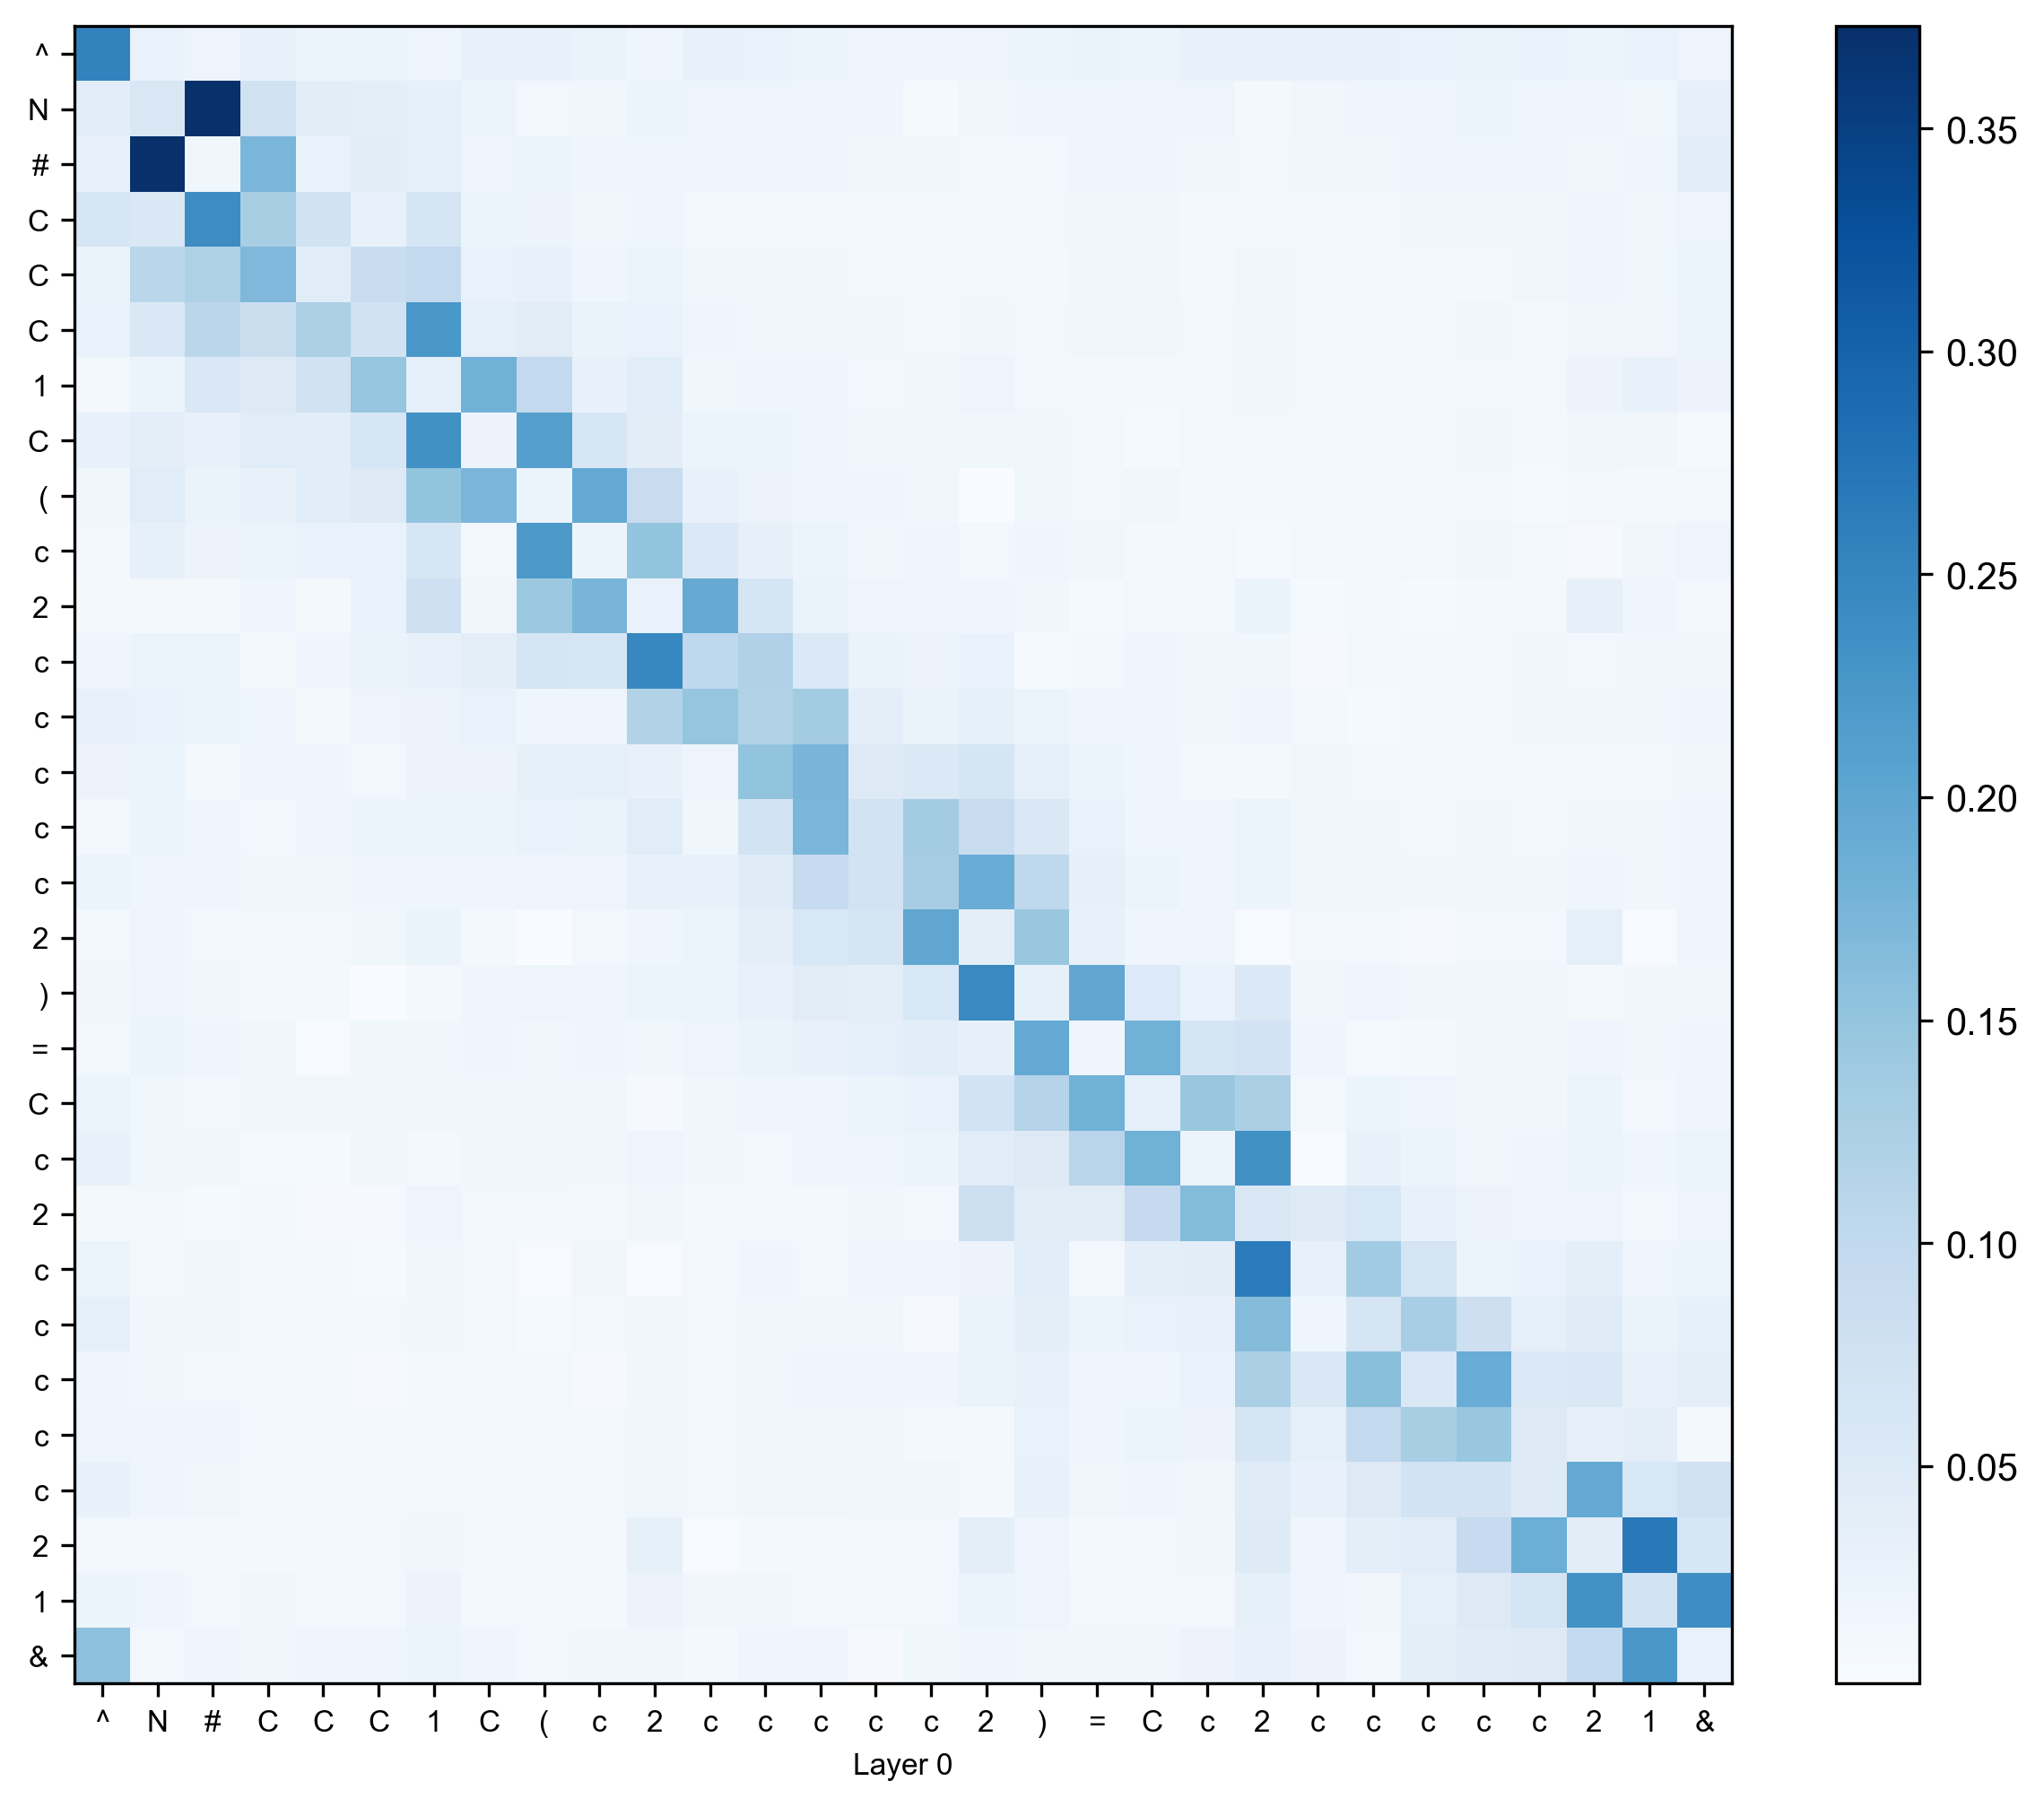

In [238]:
# 可视化 encoder
encoder_input_tokens_sample = encoder_input_tokens[SELECT_SAMPLE]
attns_encoder_sample = attns_encoder[LAYER, SELECT_SAMPLE, :, :]
encoder_tokens_len = get_sample_len(tokens_sample=encoder_input_tokens_sample)

visualize_token2token_scores(
    attns_encoder_sample[:encoder_tokens_len, :encoder_tokens_len],
    encoder_input_tokens_sample[:encoder_tokens_len],
    encoder_input_tokens_sample[:encoder_tokens_len],
    LAYER,
    figsize=(10, 8),
    dpi=DPI,
    rotation=0,
)

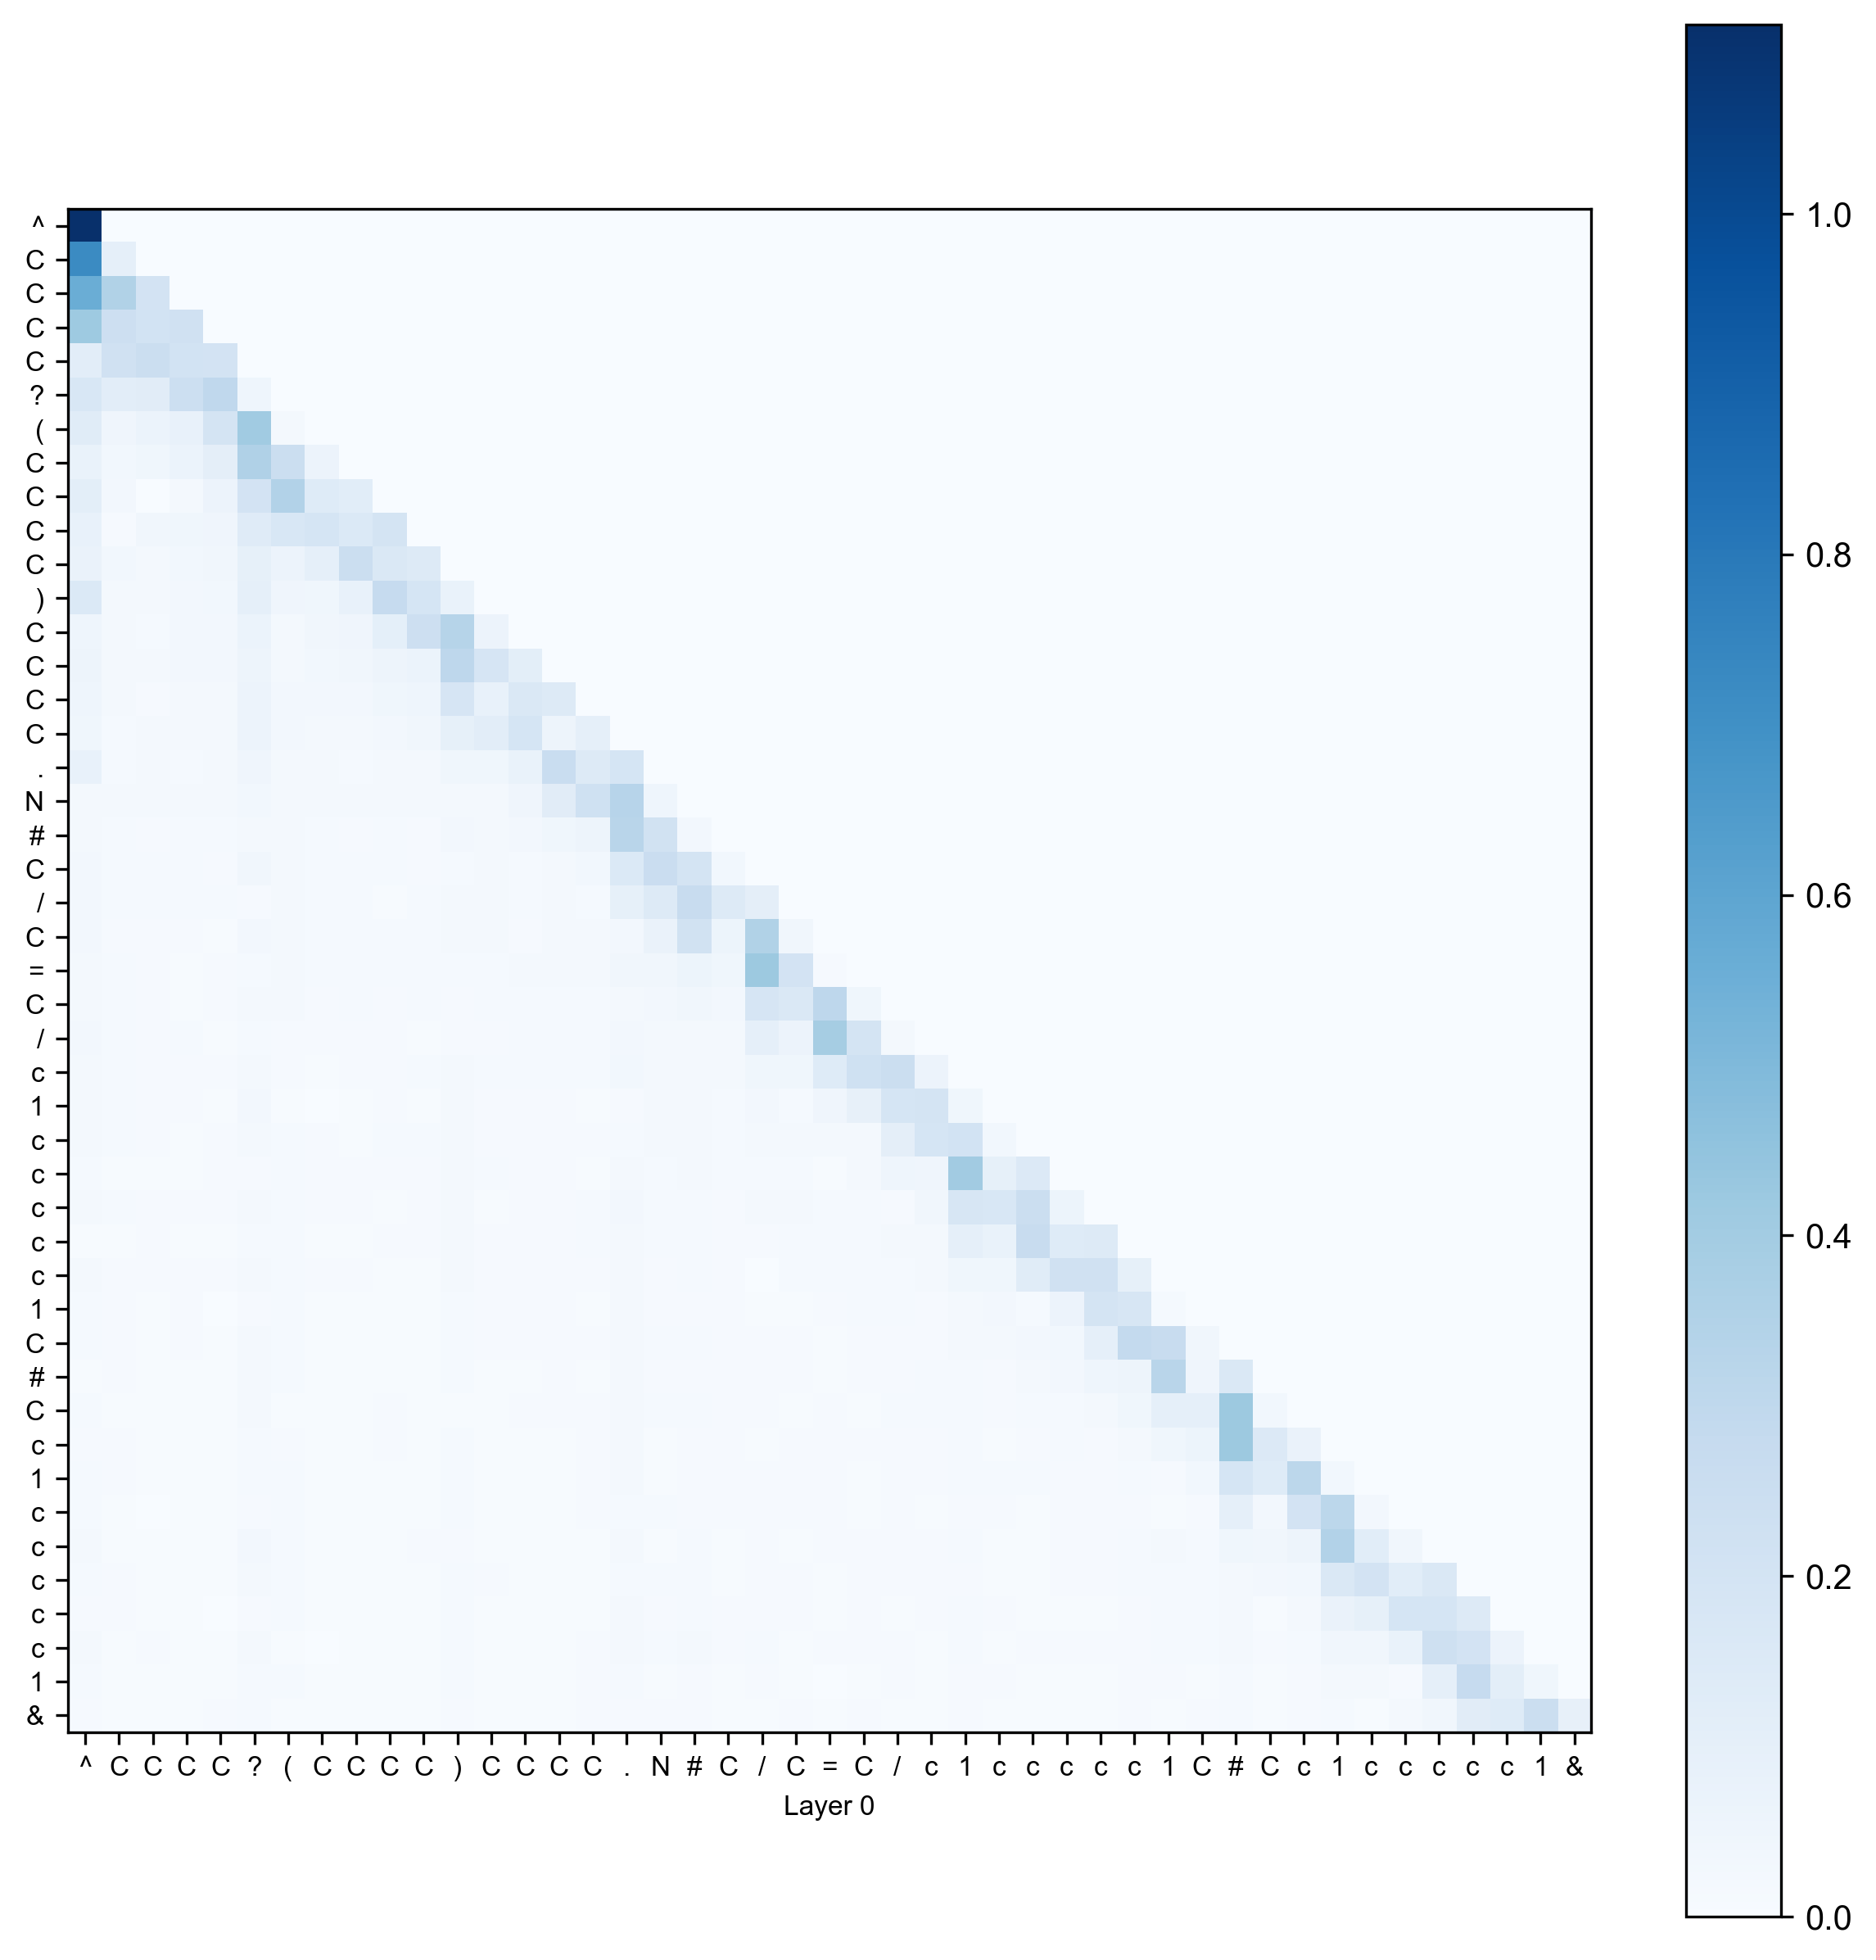

In [239]:
# 可视化 decoder
decoder_input_tokens_sample = decoder_input_tokens[SELECT_SAMPLE]
attns_decoder_sample = attns_decoder[LAYER, SELECT_SAMPLE, :, :]
decoder_tokens_len = get_sample_len(tokens_sample=decoder_input_tokens_sample)

visualize_token2token_scores(
    attns_decoder_sample[:decoder_tokens_len, :decoder_tokens_len],
    decoder_input_tokens_sample[:decoder_tokens_len],
    decoder_input_tokens_sample[:decoder_tokens_len],
    LAYER,
    figsize=(10, 10),
    dpi=DPI,
    rotation=0
)

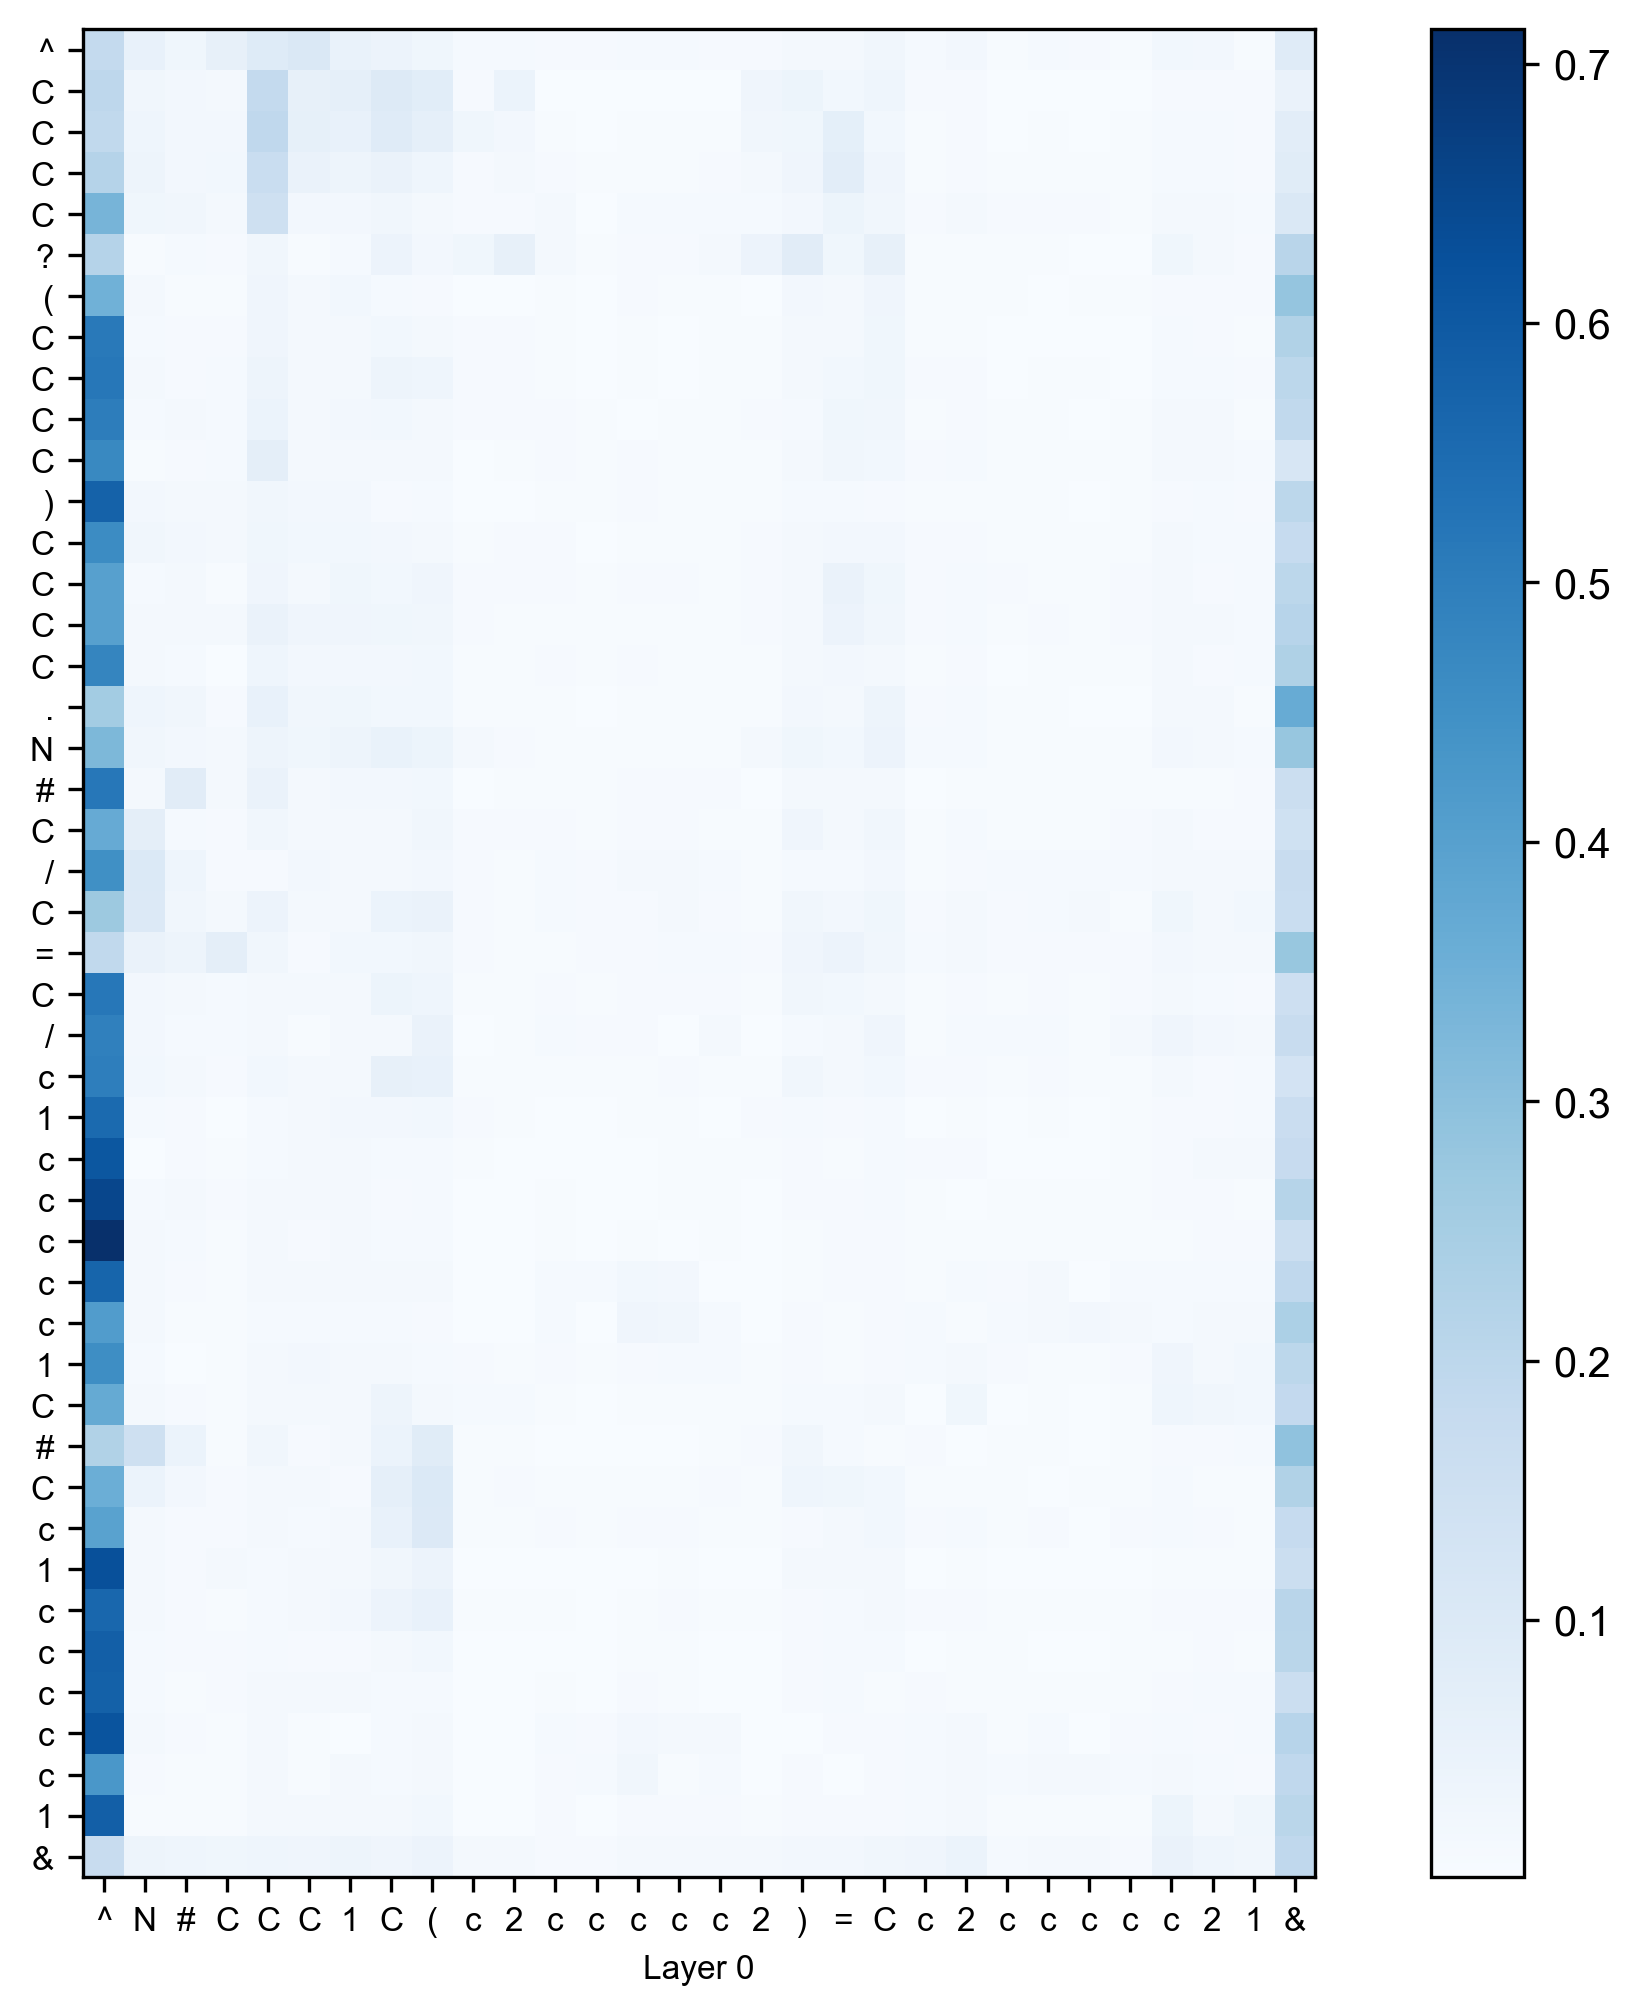

In [240]:
# 可视化 dncoder_mha
attns_decoder_mha_sample = attns_decoder_mha[LAYER, SELECT_SAMPLE, :, :]

visualize_token2token_scores(
    attns_decoder_mha_sample[:decoder_tokens_len, :encoder_tokens_len],
    encoder_input_tokens_sample[:encoder_tokens_len],
    decoder_input_tokens_sample[:decoder_tokens_len],
    LAYER,
    figsize=(10, 8),
    dpi=DPI,
    rotation=0,
)

In [241]:
rxn_smiles, src_smiles, tgt_smiles = tokens2reaction(src_tokens=decoder_input_tokens_sample, tgt_tokens=encoder_input_tokens_sample)
pred_src_smiles = pd.read_pickle(PREDCTED_PATH).loc[SELECT_SAMPLE, "prediction_0"]
print("The backword reaction in forward format is:")
print(rxn_smiles)
print("The top 1 pred backword reaction in forward format is:")
print(pred_src_smiles + '>>' + tgt_smiles)

The backword reaction in forward format is:
CCCC?(CCCC)CCCC.N#C/C=C/c1ccccc1C#Cc1ccccc1>>N#CCC1C(c2ccccc2)=Cc2ccccc21
The top 1 pred backword reaction in forward format is:
CCCC?(CCCC)CCCC.C(#Cc1ccccc1/C=C/C#N)c1ccccc1>>N#CCC1C(c2ccccc2)=Cc2ccccc21


In [242]:
reactant = Chem.MolFromSmiles(src_smiles)
product = Chem.MolFromSmiles(tgt_smiles)
display(Draw.MolToImage(reactant), Draw.MolToImage(product))

RDKit ERROR: [19:49:45] SMILES Parse Error: syntax error while parsing: CCCC?(CCCC)CCCC.N#C/C=C/c1ccccc1C#Cc1ccccc1
RDKit ERROR: [19:49:45] SMILES Parse Error: Failed parsing SMILES 'CCCC?(CCCC)CCCC.N#C/C=C/c1ccccc1C#Cc1ccccc1' for input: 'CCCC?(CCCC)CCCC.N#C/C=C/c1ccccc1C#Cc1ccccc1'


ValueError: Null molecule provided